<a href="https://colab.research.google.com/github/ArindamBanerji/wip_expts/blob/wip_main/classify_struct_data_prepro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

In [2]:
tf.__version__

'2.9.2'

In [3]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

1668792/1668792 [==============================] - 0s 0us/step


In [4]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [5]:
!pip install  sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 727 kB/s 


In [6]:
import sweetviz as sv   #analyzing the dataset

data_report = sv.analyze(dataframe, pairwise_analysis="on")
# uncomment the below line for full report 
# data_report.show_notebook (layout="vertical", scale=1.25)

                                             |          | [  0%]   00:00 -> (? left)

In [7]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [9]:
# do the train, test & val split 
train, val, test = np.split(dataframe.sample(frac=1), 
                            [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [10]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


 Creat an input pipeline using tf.data

Next, create a utility function that converts each training, validation, and test set DataFrame into a tf.data.Dataset, then shuffles and batches the data.

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [13]:
import sys 
print (sys.version)

3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]


In [14]:
!pip show ipykernel

Name: ipykernel
Version: 5.3.4
Summary: IPython Kernel for Jupyter
Home-page: https://ipython.org
Author: IPython Development Team
Author-email: ipython-dev@scipy.org
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: tornado, ipython, jupyter-client, traitlets
Required-by: notebook, jupyter-console, ipywidgets, google-colab


In [12]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [15]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor(
[[ 2]
 [ 4]
 [72]
 [ 2]
 [24]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 0], shape=(5,), dtype=int64)


In [16]:
# Normaalization for numerical features

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [17]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.83149236],
       [-0.83149236],
       [ 0.13070436],
       [-0.83149236],
       [-0.83149236]], dtype=float32)>

In [18]:
# helper functiojn to handle categorical features

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [19]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [20]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [21]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [22]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [23]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [24]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [26]:
# create & compile the model 

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

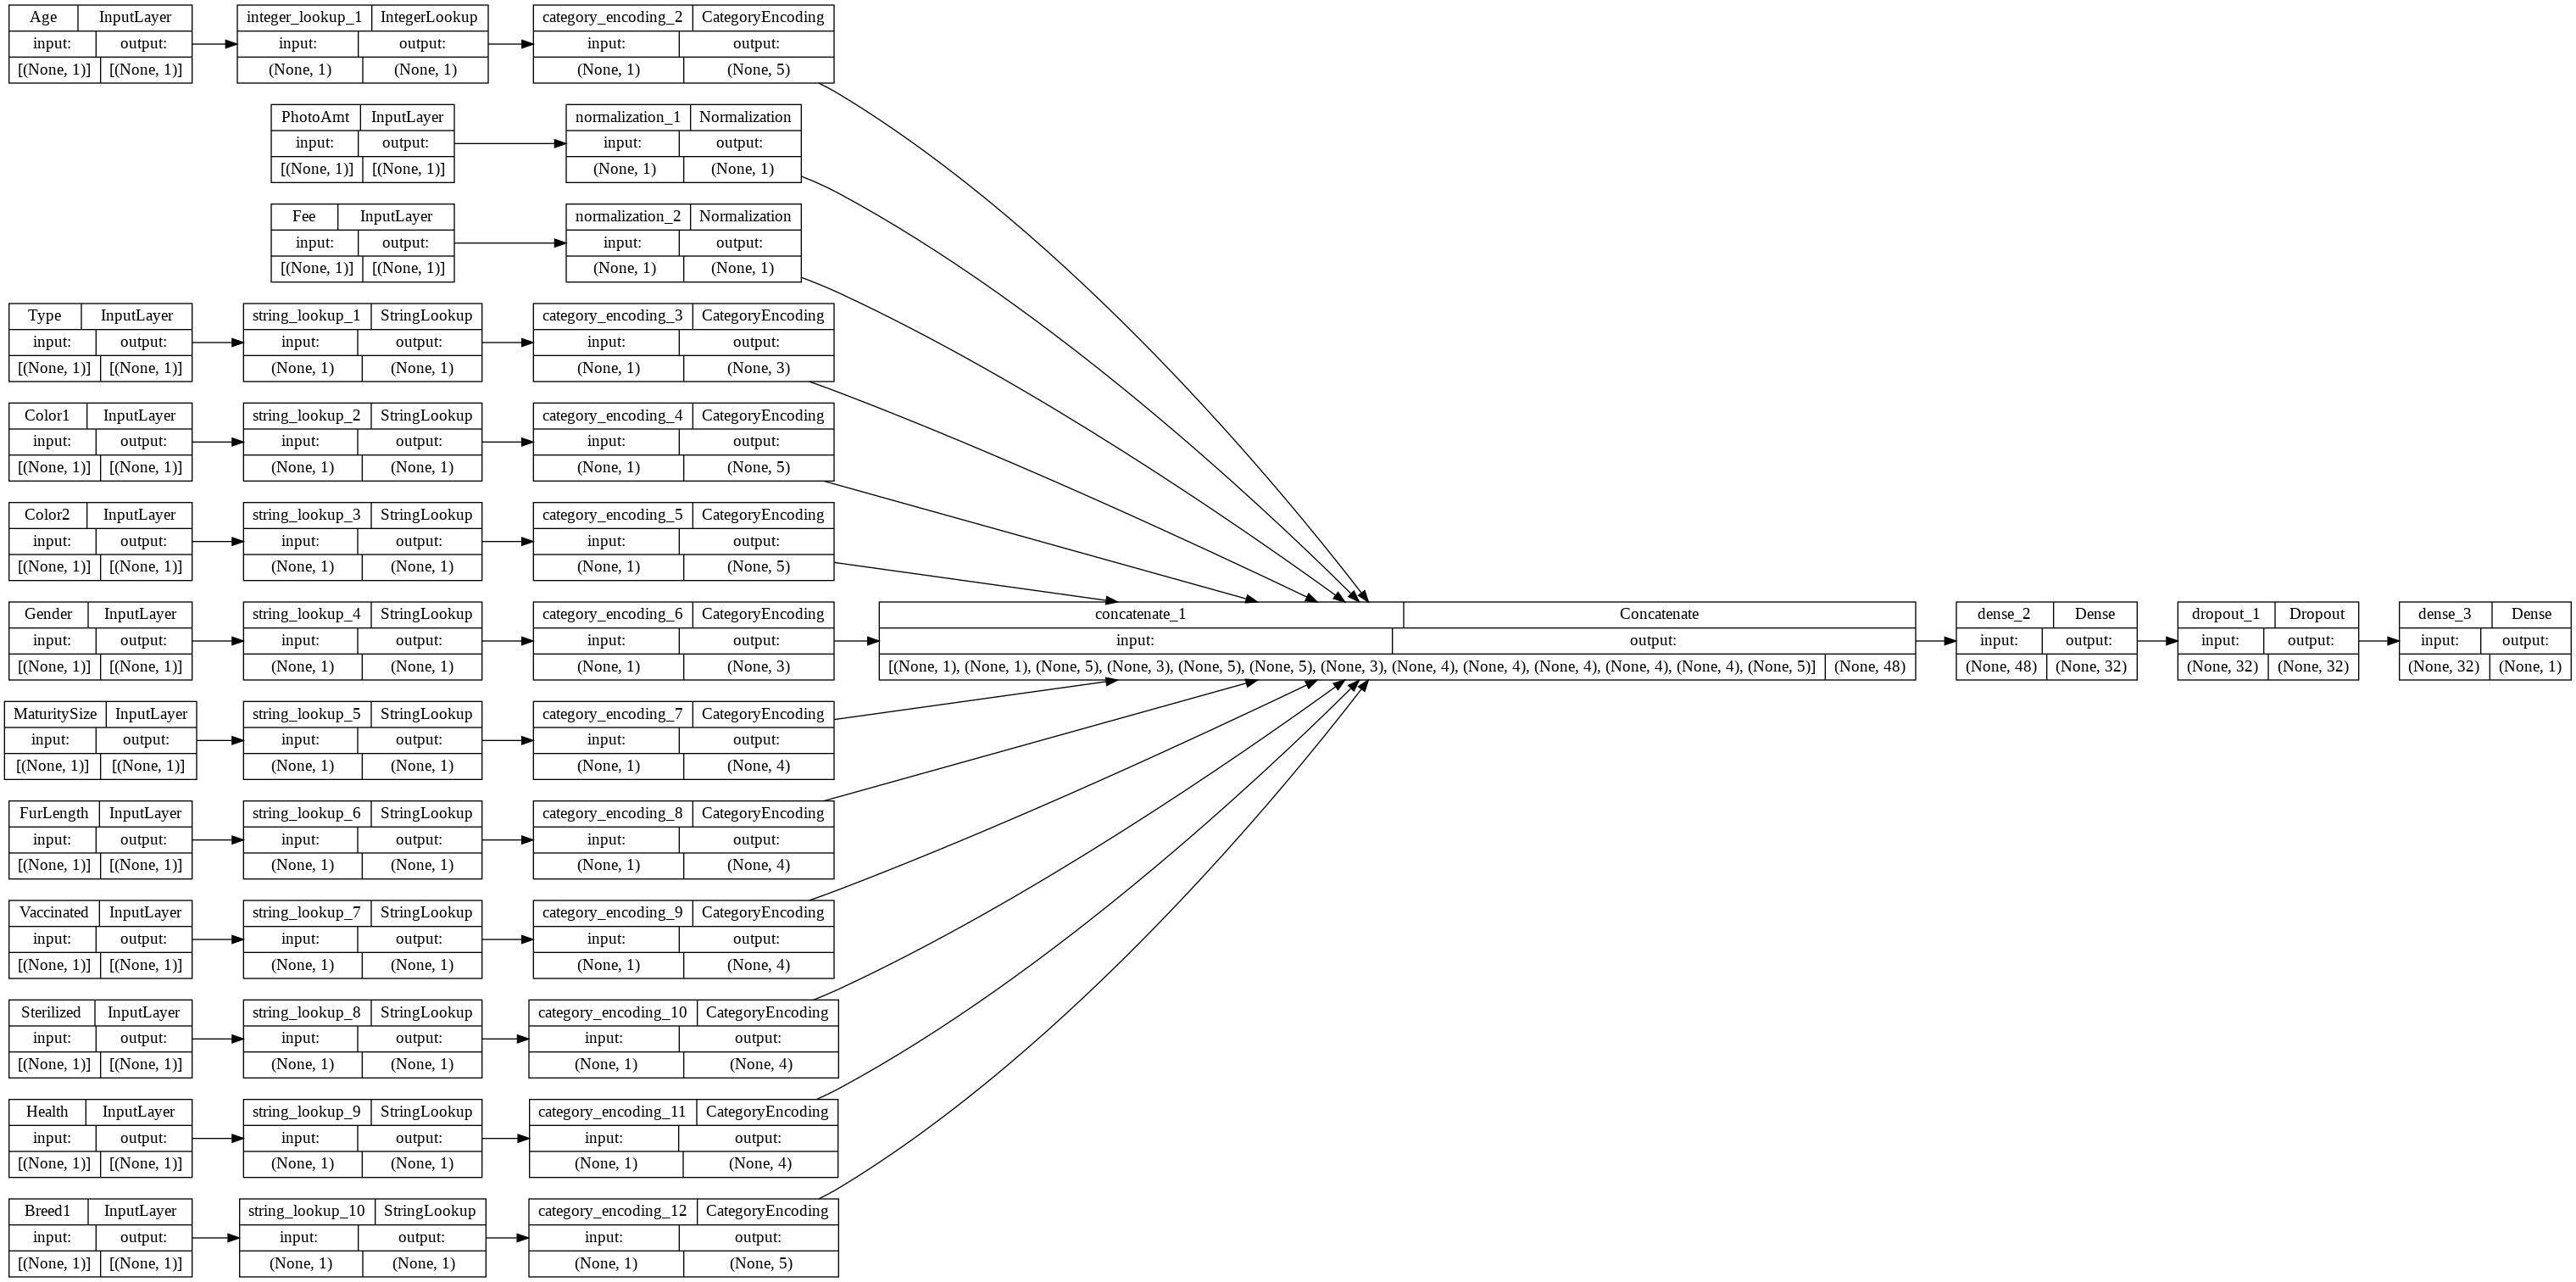

In [28]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [29]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


37/37 [==============================] - 3s 22ms/step - loss: 0.6731 - accuracy: 0.5491 - val_loss: 0.5775 - val_accuracy: 0.7244
Epoch 2/10
37/37 [==============================] - 0s 6ms/step - loss: 0.6053 - accuracy: 0.6353 - val_loss: 0.5488 - val_accuracy: 0.7270
Epoch 3/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5733 - accuracy: 0.6713 - val_loss: 0.5335 - val_accuracy: 0.7270
Epoch 4/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5556 - accuracy: 0.6802 - val_loss: 0.5260 - val_accuracy: 0.7400
Epoch 5/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5502 - accuracy: 0.7003 - val_loss: 0.5210 - val_accuracy: 0.7392
Epoch 6/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5472 - accuracy: 0.7007 - val_loss: 0.5181 - val_accuracy: 0.7374
Epoch 7/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5403 - accuracy: 0.7057 - val_loss: 0.5148 - val_accuracy: 0.7366
Epoch 8/10
37/37 [============

In [30]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 5ms/step - loss: 0.4943 - accuracy: 0.7617
Accuracy 0.7616984248161316


Inference

In [31]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

In [32]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - 1s 730ms/step
This particular pet had a 79.6 percent probability of getting adopted.
